# Lab 1 

# PART A

In [1]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



In [2]:
# Convert translation velocities to angular velocities based on pitch of lead screw
folder_path = os.path.join('Data', 'part a')
file_names = os.listdir(folder_path)
file_names.sort()
pitch = 0.02*1000  # in mm

dataframes = {}
for fname in file_names:
    file_path = os.path.join(folder_path, fname)
    df = pd.read_csv(file_path, skiprows=8)
    key = os.path.splitext(fname)[0]  # e.g., 'V_90'
    dataframes[key] = df

for key, df in dataframes.items():
    # Remove 'V_' prefix and extract the numeric value from the key
    try:
        target_value = float(key.replace('V_', ''))
    except ValueError:
        continue  # skip if key is not a number

    # Drop rows with any NaN values
    df = df.dropna()

    # Filter rows where Enc2_ActVelo is within ±1 of target_value
    filtered_df = df[(np.abs(df.iloc[:, 4]) > target_value - 0.5) & (np.abs(df.iloc[:, 4]) < target_value + 0.5)]

    dataframes[key] = filtered_df.reset_index(drop=True)

print(dataframes['V_160'].head())

    Name  Enc1_ActPos (1)  Enc2_ActPos  Enc1_ActVelo  Enc2_ActVelo      Vsig
0    278          42.9955      43.0117    159.464799    159.519390  1.169817
1  278.5          43.0755      43.0922    159.490285    159.589895  1.151693
2    279          43.1554      43.1721    159.505033    159.599900  1.136332
3  279.5          43.2359      43.2522    159.576222    159.628476  1.128448
4    280          43.3162      43.3323    159.624973    159.655692  1.158135


In [3]:
# Sort the dataframes dictionary by keys in ascending order
dataframes = dict(sorted(dataframes.items(), key=lambda x: float(x[0].replace('V_', ''))))

In [4]:
# Add a column to each dataframe in dataframes with angular velocity
pitch = 0.02*1000
for key, df in dataframes.items():
    # Calculate angular velocity: 2*pi*(Enc2_ActVelo)/pitch
    df['Angular_Velocity'] = (2 * math.pi * df.iloc[:, 4]) / pitch
    dataframes[key] = df

print(dataframes['V_160'].iloc[:,5])

0       1.169817
1       1.151693
2       1.136332
3       1.128448
4       1.158135
          ...   
1822   -1.329035
1823   -1.275345
1824   -1.286399
1825   -1.258426
1826   -1.249427
Name: Vsig, Length: 1827, dtype: float64


In [5]:
Current_gain = 0.887
Motor_const = 0.72

for key, df in dataframes.items():
    df['Torque_Nm'] = df.iloc[:,5] * Motor_const * Current_gain


In [6]:
dataframes['V_160']['Torque_Nm']

0       0.747092
1       0.735517
2       0.725707
3       0.720672
4       0.739631
          ...   
1822   -0.848775
1823   -0.814486
1824   -0.821546
1825   -0.803681
1826   -0.797934
Name: Torque_Nm, Length: 1827, dtype: float64

In [7]:
for key, df in dataframes.items():
    if df.empty:
        continue  # skip empty DataFrames

    signal = df.iloc[:, 5]
    half_index = len(signal) // 2
    avg = signal.iloc[100:half_index-200].mean()
    print(f"{key}: Average voltage= {avg}")

    # Create mask for values within ±0.3 of avg or -avg
    mask = (
        (signal >= avg - 0.1) & (signal <= avg + 0.1)
    ) | (
        (signal >= -avg - 0.1) & (signal <= -avg + 0.1)
    )

    # Apply mask and update DataFrame
    filtered_df = df[mask].reset_index(drop=True)
    dataframes[key] = filtered_df



V_15: Average voltage= 0.47695698309341666
V_20: Average voltage= 0.5346244402680932
V_25: Average voltage= 0.5737684102466547
V_30: Average voltage= 0.599839361495313
V_35: Average voltage= 0.6356724826764784
V_40: Average voltage= 0.6685263831341588
V_45: Average voltage= 0.7007965138570944
V_50: Average voltage= 0.7287883691763761
V_60: Average voltage= 0.7814251845588249
V_70: Average voltage= 0.833051024865169
V_80: Average voltage= 0.881810184382415
V_90: Average voltage= 0.9259832690743591
V_100: Average voltage= 0.9674116427007824
V_120: Average voltage= 1.0456840909170118
V_140: Average voltage= 1.1220093750338191
V_160: Average voltage= 1.186977868034514


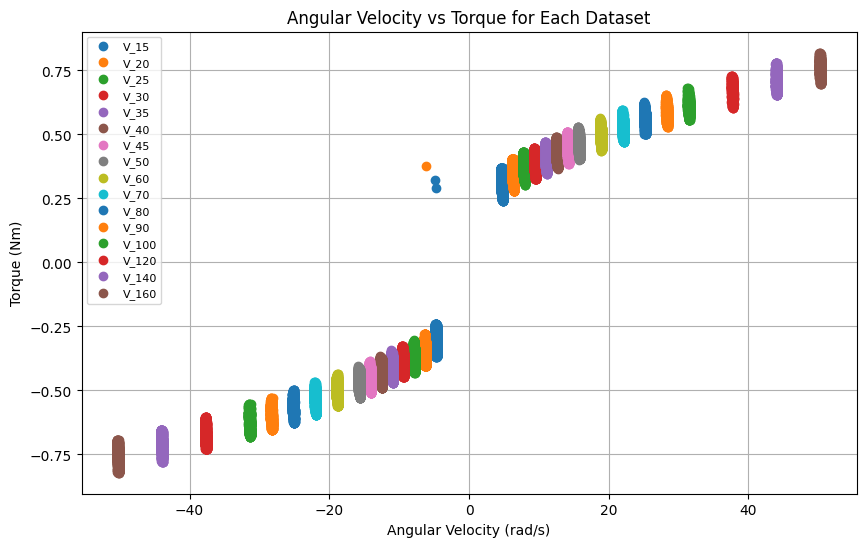

In [8]:

plt.figure(figsize=(10, 6))
for key, df in dataframes.items():
    plt.plot(df['Angular_Velocity'], df['Torque_Nm'],'o', label=key)
    
plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Angular Velocity vs Torque for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()


Positive fit: slope = 0.01072, intercept = 0.27630
Negative fit: slope = 0.01069, intercept = -0.28346


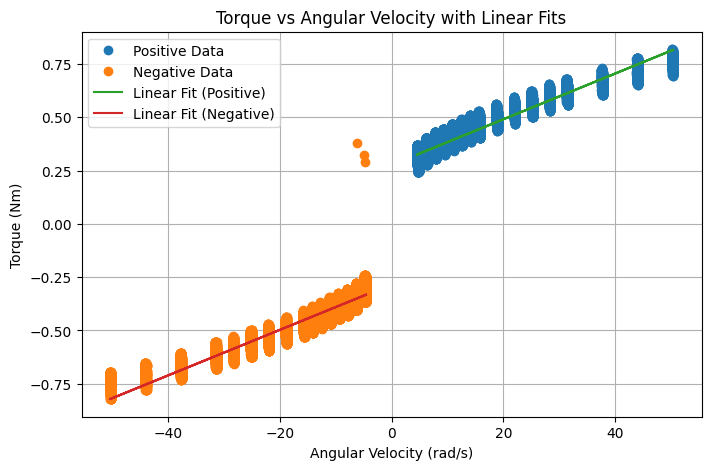

In [9]:
# Extract positive and negative angular velocity and torque from dataframes
positive_w = []
positive_torque = []
negative_w = []
negative_torque = []

for key, df in dataframes.items():
    if df.empty:
        continue
    # Positive side: Angular_Velocity > 0
    pos_mask = df['Angular_Velocity'] > 0
    positive_w.extend(df.loc[pos_mask, 'Angular_Velocity'])
    positive_torque.extend(df.loc[pos_mask, 'Torque_Nm'])
    # Negative side: Angular_Velocity < 0
    neg_mask = df['Angular_Velocity'] < 0
    negative_w.extend(df.loc[neg_mask, 'Angular_Velocity'])
    negative_torque.extend(df.loc[neg_mask, 'Torque_Nm'])

# Linear fit for positive side
fit_pos = np.polyfit(positive_w, positive_torque, 1)
fit_line_pos = np.polyval(fit_pos, positive_w)

# Linear fit for negative side
fit_neg = np.polyfit(negative_w, negative_torque, 1)
fit_line_neg = np.polyval(fit_neg, negative_w)

print(f"Positive fit: slope = {fit_pos[0]:.5f}, intercept = {fit_pos[1]:.5f}")
print(f"Negative fit: slope = {fit_neg[0]:.5f}, intercept = {fit_neg[1]:.5f}")

# Plot data and fit lines
plt.figure(figsize=(8, 5))
plt.plot(positive_w, positive_torque, 'o', label='Positive Data')
plt.plot(negative_w, negative_torque, 'o', label='Negative Data')
plt.plot(positive_w, fit_line_pos, '-', label='Linear Fit (Positive)')
plt.plot(negative_w, fit_line_neg, '-', label='Linear Fit (Negative)')
plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs Angular Velocity with Linear Fits')
plt.legend()
plt.grid(True)
plt.show()

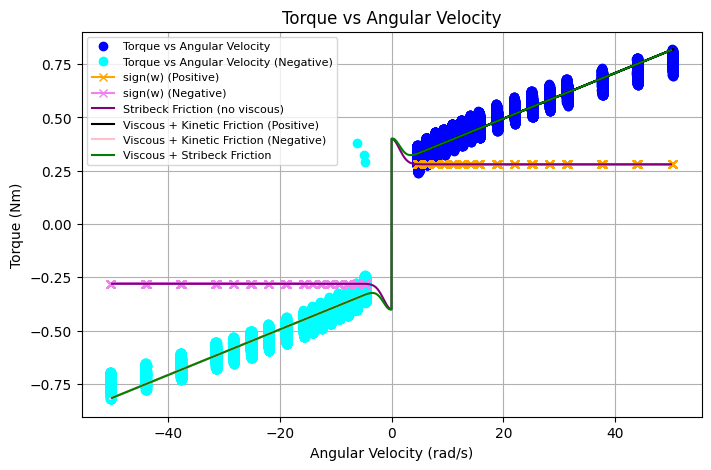

In [10]:
# Calculate sign of angular velocities
sign_pos = np.sign(positive_w)
sign_neg = np.sign(negative_w)
total_angular_velocity = positive_w + negative_w
total_angular_velocity.sort()

# Calculate torque using y-intercepts and sign(w)
torque_yint_pos = [0.28 * s for s in sign_pos]
torque_yint_neg = [0.28 * s for s in sign_neg]

import numpy as np

def stribeck_no_viscous(omega, Ts, Tc, vs, p=2, smooth=True, eps=1e-3):
    """
    Stribeck friction torque without viscous term.

    Parameters
    ----------
    omega : float or np.ndarray
        Angular velocity (rad/s).
    Ts : float
        Static (breakaway) friction torque amplitude.
    Tc : float
        Coulomb (kinetic) friction torque amplitude.
    vs : float
        Stribeck characteristic velocity (rad/s).
    p : int or float, optional
        Shape exponent of the decay (default=2).
    smooth : bool, optional
        Use smooth sign (tanh) if True, else hard sign (default=True).
    eps : float, optional
        Smoothing width for tanh sign (ignored if smooth=False).

    Returns
    -------
    T : float or np.ndarray
        Friction torque.
    """
    g = Tc + (Ts - Tc) * np.exp(- (np.abs(omega) / vs) ** p)
    if smooth:
        s = np.tanh(omega / eps)
    else:
        s = np.sign(omega)
    return g * s

# Parameters
Ts = 0.4  # Nm (static friction)
Tc = 0.28 # Nm (Coulomb friction)
vs = 2 # rad/s (Stribeck velocity)

# Angular velocity sweep
# omega_vals = np.array(total_angular_velocity)
omega_vals = np.linspace(-50, 50, 10000)  # rad/s

# Compute friction
T_vals = stribeck_no_viscous(omega_vals, Ts, Tc, vs, p=2, smooth=True)

# T sign(w) model with kinetic friction
viscous_torque_pos = []
viscous_torque_neg = []

# Viscous + Kinetic Friction
for w in positive_w:
    viscous_torque_pos.append(0.28 * np.sign(w) + 0.010705*w)
for w in negative_w:
    viscous_torque_neg.append(0.28 * np.sign(w) + 0.010705*w)

# Viscous + Stribeck friction
viscous_stribeck_torque = []
for w in omega_vals:
    viscous_stribeck_torque.append(stribeck_no_viscous(w, Ts, Tc, vs, p=2, smooth=True) + 0.010705*w)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(positive_w, positive_torque, 'o', label='Torque vs Angular Velocity', color = 'blue')
plt.plot(negative_w, negative_torque, 'o', label='Torque vs Angular Velocity (Negative)', color = 'cyan')
plt.plot(positive_w, torque_yint_pos, 'x-', label='sign(w) (Positive)', color = 'orange')
plt.plot(negative_w, torque_yint_neg, 'x-', label='sign(w) (Negative)', color = 'violet')
plt.plot(omega_vals, T_vals, label='Stribeck Friction (no viscous)', color='purple')
plt.plot(positive_w, viscous_torque_pos, label = 'Viscous + Kinetic Friction (Positive)', color='black')
plt.plot(negative_w, viscous_torque_neg, label = 'Viscous + Kinetic Friction (Negative)', color='pink')
plt.plot(omega_vals, viscous_stribeck_torque, label='Viscous + Stribeck Friction', color='green')

plt.xlabel('Angular Velocity (rad/s)')
plt.ylabel('Torque (Nm)')
plt.title('Torque vs Angular Velocity')
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

# PART B

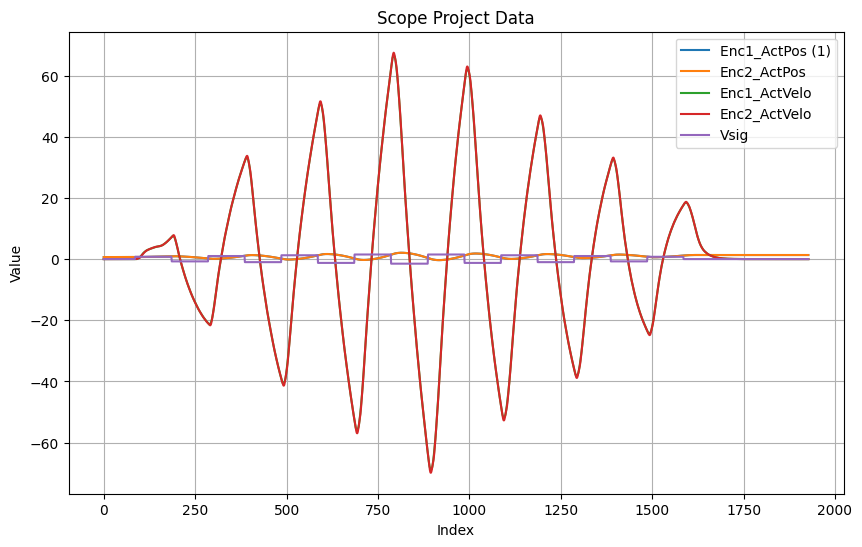

In [11]:
# Load the CSV file, skipping the first 8 rows
scope_df = pd.read_csv('C:\\Users\\kylea\\Repos\\MECH_467_Labs\\Lab1\\Data\\part b\\Scope Project.csv', skiprows=8)
# Remove rows with NaN values
scope_df = scope_df.dropna()
# Plot all columns
scope_df.plot(figsize=(10, 6), title='Scope Project Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [12]:
scope_df

,Name,Enc1_ActPos (1),Enc2_ActPos,Enc1_ActVelo,Enc2_ActVelo,Vsig
0,0,0.6563,0.6581,0.000000,0.000000,0.0
1,0.5,0.6563,0.6581,0.000000,0.000000,0.0
2,1,0.6563,0.6581,0.000000,0.000000,0.0
3,1.5,0.6563,0.6581,0.000000,0.000000,0.0
4,2,0.6563,0.6581,0.000000,0.000000,0.0
...,...,...,...,...,...,...
1923,961.5,1.3271,1.3291,0.000813,-0.000027,0.0
1924,962,1.3271,1.3291,0.000774,-0.000025,0.0
1925,962.5,1.3271,1.3291,0.000738,-0.000024,0.0
1926,963,1.3271,1.3291,0.000702,-0.000023,0.0


0.1
[0.0004166 0.0016664 0.0024996 0.0016664 0.0004166][ 1.         -3.18063855  3.86119435 -2.11215536  0.43826514]
[0.20618272 0.20618272 0.20618272 ... 0.41695145 0.41695184 0.41695218]


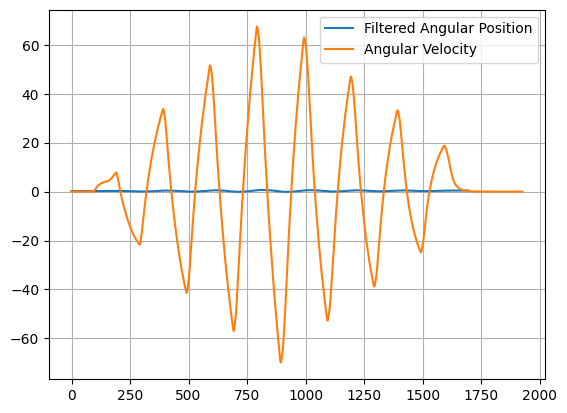

In [13]:
# Filter 
from scipy.signal import butter, filtfilt

# Example values
Ts = 0.5/1000       # sampling period (s) -> fs = 1/Ts
fs = 1 / Ts       # sampling frequency
fc = 100         # cutoff frequency (Hz)

df['Angular_Position'] = (2 * math.pi * scope_df['Enc1_ActPos (1)']) / pitch

# Design 4th-order Butterworth low-pass filter
Wn = fc / (fs / 2)   # normalize cutoff to Nyquist frequency
print(Wn)
# Wn = 2*100*Ts
b, a = butter(4, Wn, btype='low')
print(str(b) + "" + str(a))
# Apply zero-phase filtering
theta_filt = filtfilt(b, a, df['Angular_Position'])
# theta_filt -= 0.6563

valid_mask = ~np.isnan(theta_filt)

print(theta_filt)
plt.plot(theta_filt, label = "Filtered Angular Position")
plt.plot(scope_df['Enc2_ActVelo'], label = "Angular Velocity")
plt.legend()
plt.grid(True)


(1698,)
(1698,)


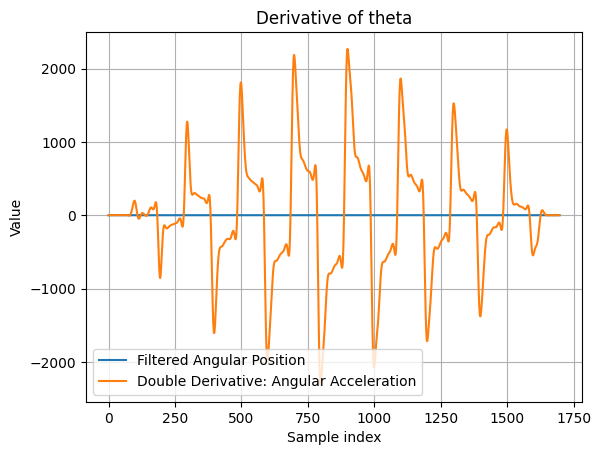

In [14]:
# Carry out the derivativ
from deriv import deriv
print(theta_filt.shape)
omega = deriv(theta_filt, Ts)
print(omega[0].shape)
omega_dot = deriv(omega[0], Ts)
derived_measured_angular_acc = deriv(scope_df['Enc2_ActVelo'], Ts)

plt.plot(theta_filt, label="Filtered Angular Position")
#plt.plot(derived_measured_angular_acc[0], label="Derived Measured Angular Acceleration")
plt.plot(omega_dot[0], label="Double Derivative: Angular Acceleration")
plt.title("Derivative of theta")
plt.xlabel("Sample index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()  


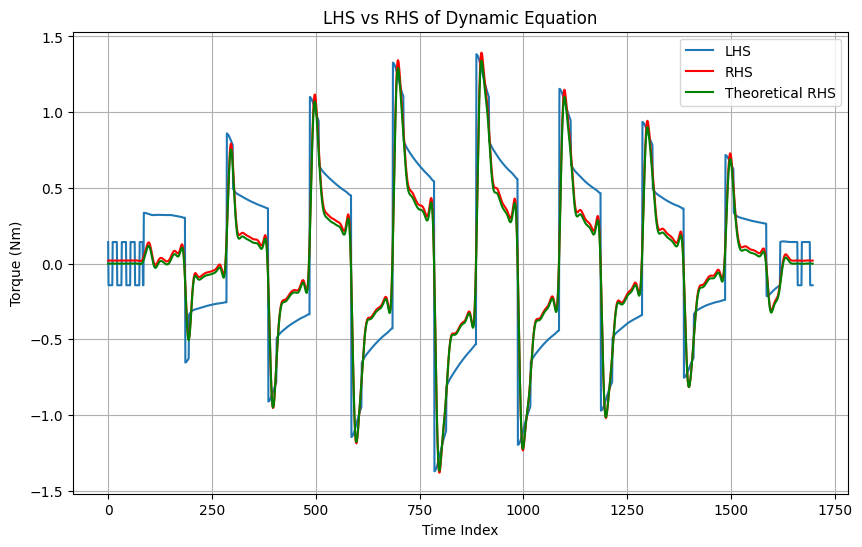

In [15]:
# Graph both LHS and RHS of dynamic Equation
# constants
# --- Common parameters ---
J = 5.904e-4
B = 0.006
K_t = 0.72
S_g = 0.887
B_e = 0.010705
mew_k = 0.0933
J_e = 6.05e-4
T_d = 0.14
mew_k = 0.1427

# omega_aligned = theta_filt[valid_mask]
# vsig_aligned = scope_df['Vsig'][valid_mask].reset_index(drop=True)

valid_indices = np.where(valid_mask)[0]
vsig_aligned = scope_df['Vsig'].iloc[valid_indices].reset_index(drop=True)

# Viscous + Stribeck friction
viscous_stribeck_torque = []
for w in omega[0]:
    viscous_stribeck_torque.append(stribeck_no_viscous(w, Ts, Tc, vs, p=2, smooth=True) + 0.00804*w)

LHS = (S_g * K_t * vsig_aligned) - (B_e * omega[0]) - mew_k*np.sign(omega[0])
RHS = J_e * omega_dot[0] + 0.02
Theoretical = J * omega_dot[0]

plt.figure(figsize=(10, 6))
plt.plot(LHS, label='LHS')
plt.plot(RHS, label='RHS', color = 'red')
plt.plot(Theoretical, label='Theoretical RHS', color = "green")
plt.title('LHS vs RHS of Dynamic Equation')
plt.xlabel('Time Index')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.grid(True)
plt.show()

# PART C

In [16]:
# Convert translation velocities to angular velocities based on pitch of lead screw
folder_path = os.path.join('Data', 'part c')
file_names = os.listdir(folder_path)
file_names.sort()
pitch = 0.02*1000  # in mm

freq_dataframes = {}
for fname in file_names:
    file_path = os.path.join(folder_path, fname)
    df = pd.read_csv(file_path, skiprows=8)
    # Remove the first letter of the file name (after removing extension)
    key = os.path.splitext(fname)[0][1:]  # e.g., 'V_90' -> '90'
    freq_dataframes[key] = df

for key, df in freq_dataframes.items():
    df['Angular_Velocity'] = deriv(df.iloc[:, 1], Ts)[0]
    freq_dataframes[key] = df

print(freq_dataframes['50'].head())

  Name  Enc1_ActPos (1)  Enc2_ActPos  Enc1_ActVelo  Enc2_ActVelo      Vsig  \
0    0          68.5786      68.6065      3.686887      3.718529  0.655771   
1  0.5          68.5814      68.6094      3.777988      3.817647  0.657827   
2    1          68.5842      68.6122      3.864750      3.902521  0.659890   
3  1.5          68.5871      68.6151      3.956905      3.992877  0.661960   
4    2          68.5900      68.6180      4.044672      4.078930  0.664039   

   Angular_Velocity  
0          5.766667  
1          5.533333  
2          5.700000  
3          5.816667  
4          5.783333  


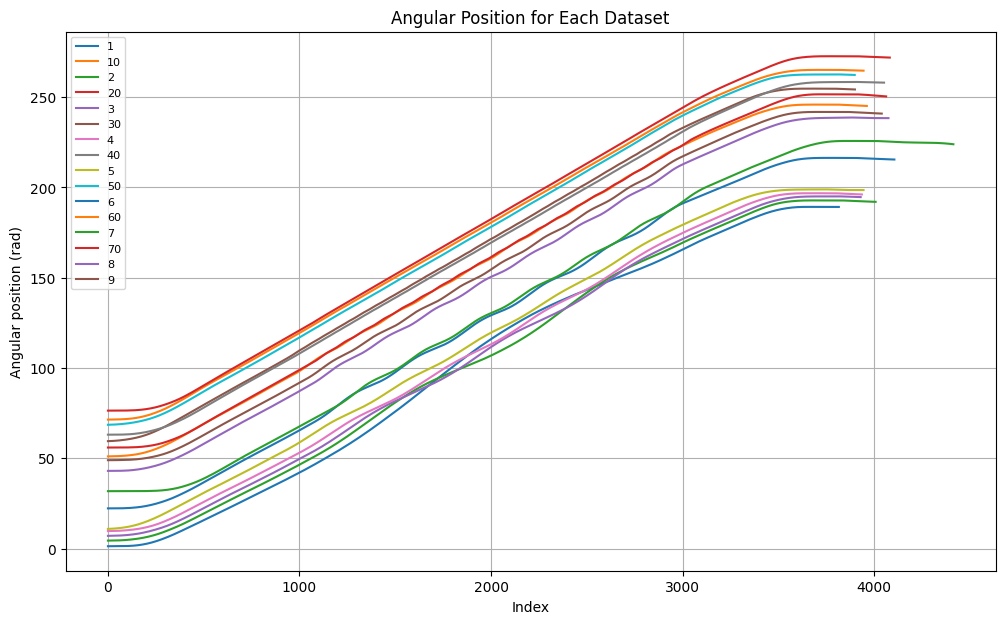

In [17]:
plt.figure(figsize=(12, 7))
for key, df in freq_dataframes.items():
    plt.plot(df['Enc1_ActPos (1)'], label=key)
plt.xlabel('Index')
plt.ylabel('Angular position (rad)')
plt.title('Angular Position for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

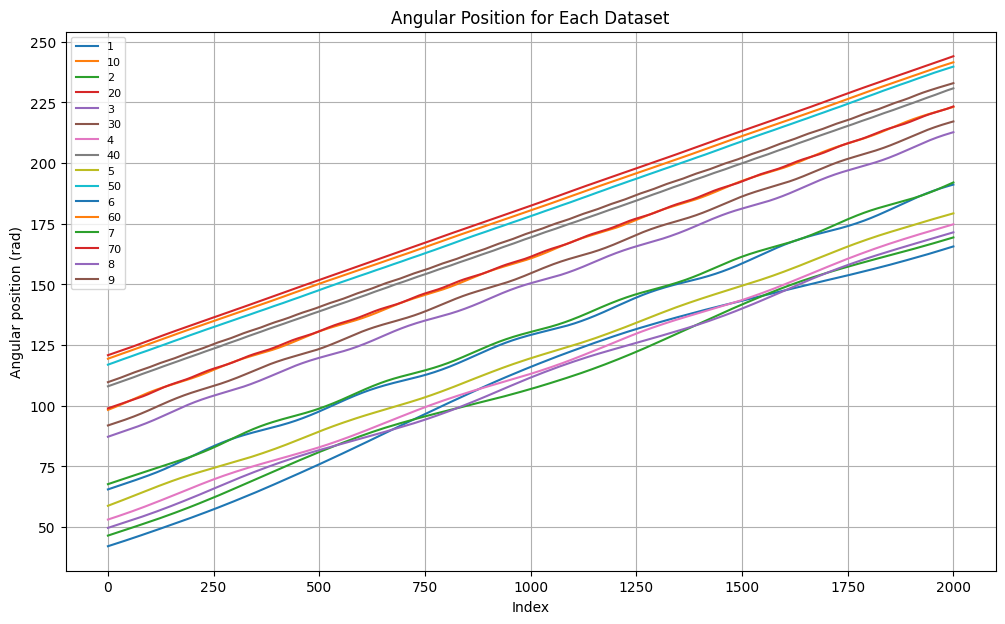

In [18]:
# Trim each dataframe in freq_dataframes to keep only rows with index between 1000 and 3000 (inclusive)
for key, df in freq_dataframes.items():
    freq_dataframes[key] = df.loc[1000:3000].reset_index(drop=True)

plt.figure(figsize=(12, 7))
for key, df in freq_dataframes.items():
    plt.plot(df['Enc1_ActPos (1)'], label=key)
plt.xlabel('Index')
plt.ylabel('Angular position (rad)')
plt.title('Angular Position for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [19]:
# Design 4th-order Butterworth low-pass filter
Wn = fc / (fs / 2)   # normalize cutoff to Nyquist frequency
print(Wn)
# Wn = 2*100*Ts
b, a = butter(4, Wn, btype='low')


0.1


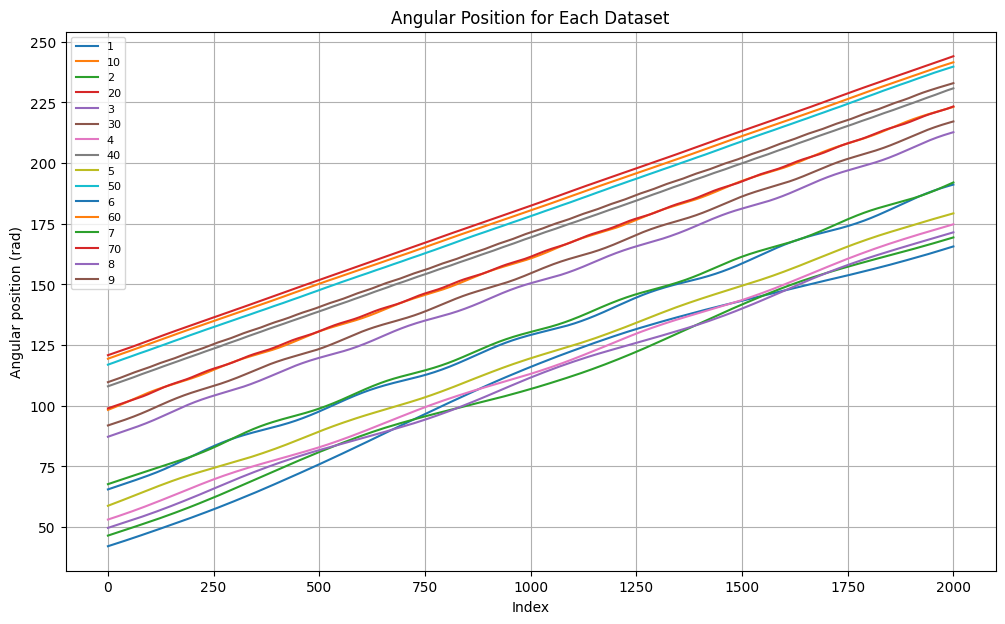

In [20]:
# Apply Butterworth filter to column number 2 ('Enc2_ActPos') for all dataframes in freq_dataframes
for key, df in freq_dataframes.items():
    filtered_col = filtfilt(b, a, df.iloc[:, 2])
    df['Enc2_ActPos_Filtered'] = filtered_col
    freq_dataframes[key] = df

plt.figure(figsize=(12, 7))
for key, df in freq_dataframes.items():
    plt.plot(df['Enc1_ActPos (1)'], label=key)
plt.xlabel('Index')
plt.ylabel('Angular position (rad)')
plt.title('Angular Position for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [21]:
# Sort the freq_dataframes dictionary by keys (dataframe names) in ascending order
freq_dataframes = dict(sorted(freq_dataframes.items(), key=lambda x: x[0]))

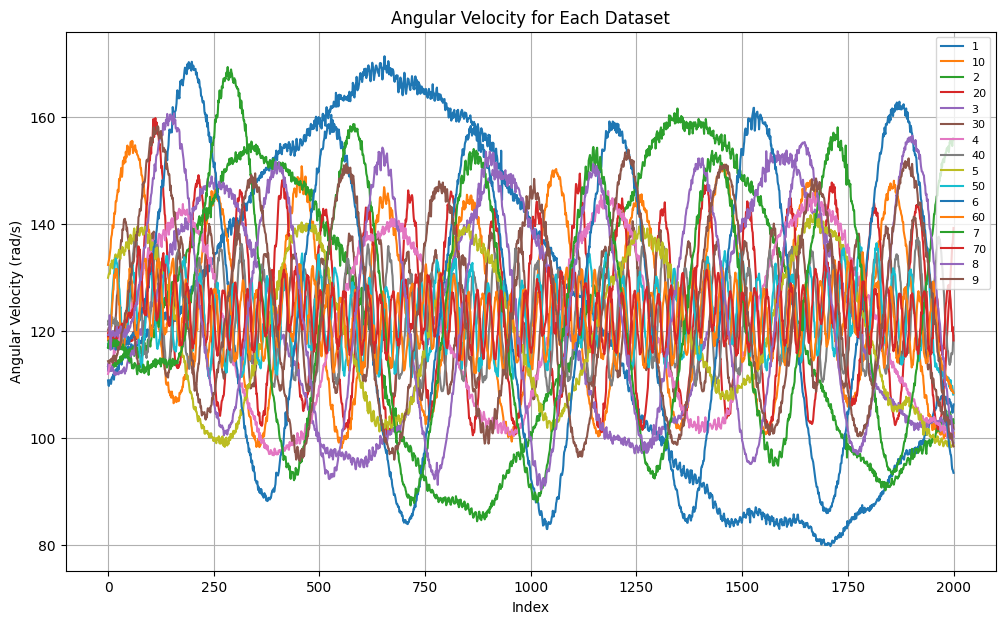

In [22]:
plt.figure(figsize=(12, 7))
for key, df in freq_dataframes.items():
    if 'Angular_Velocity' in df.columns:
        plt.plot(df['Angular_Velocity'], label=key)
plt.xlabel('Index')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [23]:
# Measure peak-to-peak magnitude (max - min) of 'Angular_Velocity' in each freq_dataframes entry
peak_to_peak_dict = {}
for key, df in freq_dataframes.items():
    if 'Angular_Velocity' in df.columns:
        peak_to_peak = df['Angular_Velocity'].max() - df['Angular_Velocity'].min()
        peak_to_peak_dict[key] = peak_to_peak

# Sort the dictionary by integer value of the keys
omega_sorted_dataframes = dict(sorted(peak_to_peak_dict.items(), key=lambda x: int(x[0])))
print(omega_sorted_dataframes)

{'1': 91.5666666666688, '2': 77.15000000002803, '3': 59.583333333307564, '4': 49.400000000009214, '5': 43.600000000015626, '6': 87.33333333331393, '7': 81.93333333334962, '8': 70.36666666665425, '9': 62.56666666666533, '10': 57.383333333305586, '20': 59.899999999988296, '30': 39.66666666661922, '40': 28.98333333340375, '50': 28.33333333332888, '60': 26.349999999936813, '70': 21.400000000070918}


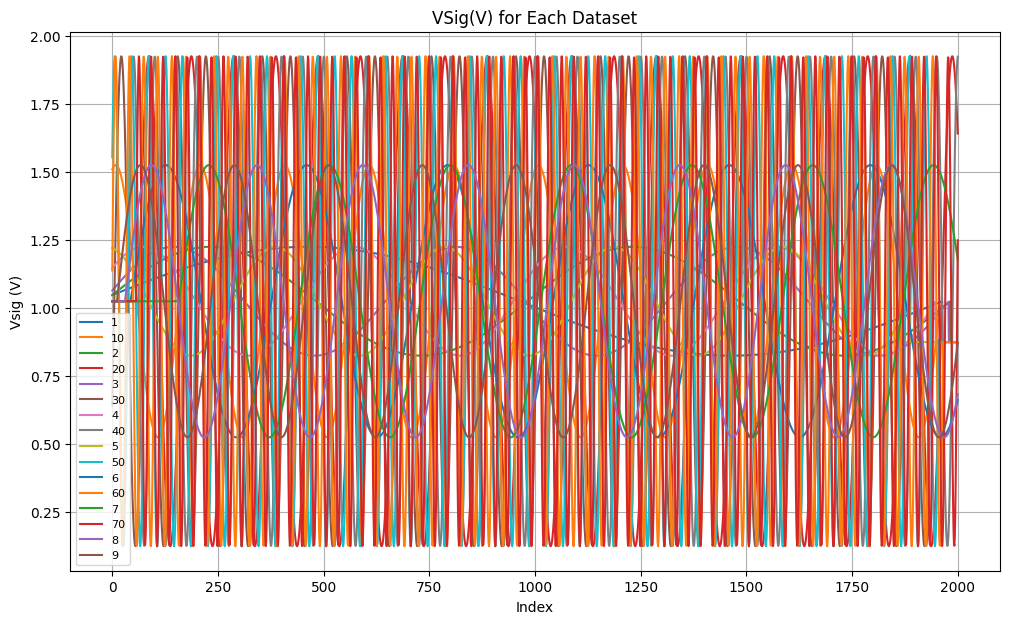

In [24]:
# Measure the peak-to-peak magnitude of 'Vsig' in each freq_dataframes entry
peak_to_peak_vsig_dict = {}
for key, df in freq_dataframes.items():
    if 'Vsig' in df.columns:
        peak_to_peak_vsig = df['Vsig'].max() - df['Vsig'].min()
        peak_to_peak_vsig_dict[key] = peak_to_peak_vsig

plt.figure(figsize=(12, 7))
for key, df in freq_dataframes.items():
    if 'Vsig' in df.columns:
        plt.plot(df['Vsig'], label=key)
plt.xlabel('Index')
plt.ylabel('Vsig (V)')
plt.title('VSig(V) for Each Dataset')
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

In [25]:
# Sort the dictionary by integer value of the keys
sorted_dataframes = dict(sorted(peak_to_peak_vsig_dict.items(), key=lambda x: int(x[0])))
print(sorted_dataframes)

{'1': 0.3999999999999999, '2': 0.3999999999999999, '3': 0.3999999999999999, '4': 0.3999999999999999, '5': 0.3999999999999999, '6': 1.0, '7': 1.0, '8': 0.9999210442038164, '9': 1.0, '10': 1.0, '20': 1.8, '30': 1.8, '40': 1.7964481111708912, '50': 1.8, '60': 1.8, '70': 1.8}


In [26]:
# Divide each value in omega_sorted_dataframes by the corresponding value in sorted_dataframes (matching keys)
ratio_dict = {}
for key in omega_sorted_dataframes:
    ratio_dict[key] = (omega_sorted_dataframes[key] / sorted_dataframes[key])
print(ratio_dict)

{'1': 228.91666666667203, '2': 192.87500000007012, '3': 148.95833333326894, '4': 123.50000000002306, '5': 109.0000000000391, '6': 87.33333333331393, '7': 81.93333333334962, '8': 70.3722229615474, '9': 62.56666666666533, '10': 57.383333333305586, '20': 33.27777777777128, '30': 22.037037037010677, '40': 16.13368799976803, '50': 15.740740740738266, '60': 14.638888888853785, '70': 11.888888888928287}


In [27]:
from scipy.signal import find_peaks
import numpy as np

phase_results = {}

for key, df in freq_dataframes.items():
    if 'Vsig' in df.columns and 'Angular_Velocity' in df.columns:
        vsig = df['Vsig'].values
        omega_signal = df['Angular_Velocity'].values

        # Find peaks
        peaks_vsig, _ = find_peaks(vsig)
        peaks_omega, _ = find_peaks(omega_signal)

        # Convert peak indices to time
        t_vsig = peaks_vsig * Ts
        t_omega = peaks_omega * Ts

        phase_lags = []
        for t_out in t_omega:
            next_input = t_vsig[t_vsig > t_out]
            if len(next_input) > 0:
                lag = next_input[0] - t_out
                phase_lags.append(lag)

        if phase_lags:
            avg_time_diff = np.mean(phase_lags)

            # Estimate period from input peaks
            if len(peaks_vsig) > 1:
                period_samples = peaks_vsig[1] - peaks_vsig[0]
            else:
                period_samples = int(fs / fc)  # fallback

            period_time = period_samples * Ts

            # Phase lag: negative if output lags input
            phase_rad = -2 * np.pi * avg_time_diff / period_time
            phase_deg = np.degrees(phase_rad)

            phase_results[key] = {
                'avg_time_diff': avg_time_diff,
                'period_time': period_time,
                'phase_rad': phase_rad,
                'phase_deg': phase_deg
            }

for key, result in phase_results.items():
    print(f"{key}: Avg lag={result['avg_time_diff']:.6f}s "
          f"(Period={result['period_time']:.6f}s) "
          f"Phase={result['phase_rad']:.3f} rad, {result['phase_deg']:.2f} deg")


1: Avg lag=0.311914s (Period=0.749500s) Phase=-2.615 rad, -149.82 deg
10: Avg lag=0.051533s (Period=0.100000s) Phase=-3.238 rad, -185.52 deg
2: Avg lag=0.208738s (Period=0.500000s) Phase=-2.623 rad, -150.29 deg
20: Avg lag=0.027097s (Period=0.050000s) Phase=-3.405 rad, -195.10 deg
3: Avg lag=0.140770s (Period=0.333000s) Phase=-2.656 rad, -152.18 deg
30: Avg lag=0.017684s (Period=0.033500s) Phase=-3.317 rad, -190.04 deg
4: Avg lag=0.117959s (Period=0.250000s) Phase=-2.965 rad, -169.86 deg
40: Avg lag=0.013235s (Period=0.025000s) Phase=-3.326 rad, -190.58 deg
5: Avg lag=0.097052s (Period=0.200000s) Phase=-3.049 rad, -174.69 deg
50: Avg lag=0.010029s (Period=0.020000s) Phase=-3.151 rad, -180.52 deg
6: Avg lag=0.085155s (Period=0.167000s) Phase=-3.204 rad, -183.57 deg
60: Avg lag=0.008724s (Period=0.016500s) Phase=-3.322 rad, -190.34 deg
7: Avg lag=0.073243s (Period=0.143000s) Phase=-3.218 rad, -184.39 deg
70: Avg lag=0.007887s (Period=0.014500s) Phase=-3.418 rad, -195.82 deg
8: Avg lag=0.

In [ ]:
%matplotlib qt

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

scale_factor = 5  # amplify input for visibility
saved_pts = {}
for key, df in freq_dataframes.items():
    if 'Vsig' in df.columns and 'Angular_Velocity' in df.columns:
        vsig = df['Vsig'].values * scale_factor
        omega_signal = df['Angular_Velocity'].values
        t = np.arange(len(vsig)) * Ts

        peaks_vsig, _ = find_peaks(df['Vsig'].values)
        peaks_omega, _ = find_peaks(omega_signal)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(t, vsig, label=f'Input (Vsig ×{scale_factor})')
        ax.plot(t, omega_signal, label='Output (Angular Velocity)')
        ax.plot(t[peaks_vsig], vsig[peaks_vsig] * scale_factor, "ro", label='Vsig peaks')
        ax.plot(t[peaks_omega], omega_signal[peaks_omega], "go", label='Omega peaks')

        ax.set_title(f"Signal Comparison: {key}")
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Amplitude (scaled)")
        ax.legend()
        ax.grid(True)

        # Let you click two points on this figure
        print(f"Click on INPUT peak, then OUTPUT peak for {key}")
        pts = plt.ginput(2, timeout=-1)
        saved_pts[key] = pts
        print(f"{key} clicked points:", pts)

        # Draw vertical lines where you clicked
        for (x, y) in pts:
            ax.axvline(x, color='k', linestyle='--')

        plt.show()


In [34]:
import numpy as np

Ts = 0.0005  # 0.5 ms sampling time

phase_results = {}

for key, pts in saved_pts.items():
    if len(pts) == 2:
        # Extract clicked times
        t_in, _ = pts[0]
        t_out, _ = pts[1]
        time_diff = t_out - t_in   # seconds

        # Interpret key as frequency in Hz (adjust if your keys are different)
        freq_hz = float(key)
        period = 1.0 / freq_hz     # seconds

        # Phase difference in radians and degrees
        phase_rad = -2 * np.pi * time_diff / period
        phase_deg = np.degrees(phase_rad)

        phase_results[key] = {
            "time_diff_s": time_diff,
            "period_s": period,
            "phase_rad": phase_rad,
            "phase_deg": phase_deg
        }

# Print results
for key, res in phase_results.items():
    print(f"Freq {key} Hz:")
    print(f"  Time diff = {res['time_diff_s']:.6f} s")
    print(f"  Period    = {res['period_s']:.6f} s")
    print(f"  Phase     = {res['phase_rad']:.3f} rad  ({res['phase_deg']:.2f}°)")


Freq 1 Hz:
  Time diff = 0.088000 s
  Period    = 1.000000 s
  Phase     = -0.553 rad  (-31.68°)
Freq 10 Hz:
  Time diff = 0.022710 s
  Period    = 0.100000 s
  Phase     = -1.427 rad  (-81.75°)
Freq 2 Hz:
  Time diff = 0.073806 s
  Period    = 0.500000 s
  Phase     = -0.927 rad  (-53.14°)
Freq 20 Hz:
  Time diff = 0.017032 s
  Period    = 0.050000 s
  Phase     = -2.140 rad  (-122.63°)
Freq 3 Hz:
  Time diff = 0.059613 s
  Period    = 0.333333 s
  Phase     = -1.124 rad  (-64.38°)
Freq 30 Hz:
  Time diff = 0.009935 s
  Period    = 0.033333 s
  Phase     = -1.873 rad  (-107.30°)
Freq 4 Hz:
  Time diff = 0.042581 s
  Period    = 0.250000 s
  Phase     = -1.070 rad  (-61.32°)
Freq 40 Hz:
  Time diff = 0.012774 s
  Period    = 0.025000 s
  Phase     = -3.211 rad  (-183.95°)
Freq 5 Hz:
  Time diff = 0.044000 s
  Period    = 0.200000 s
  Phase     = -1.382 rad  (-79.20°)
Freq 50 Hz:
  Time diff = 0.005677 s
  Period    = 0.020000 s
  Phase     = -1.784 rad  (-102.19°)
Freq 6 Hz:
  Time dif

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Example: ratio_dict = {'1': 0.8, '10': 0.5, '100': 0.1}
#          phase_results = {'1': {'phase_deg': -10}, '10': {'phase_deg': -45}, ...}

# Convert keys to floats (frequencies in Hz)
freqs = np.array([float(k) for k in ratio_dict.keys()])
# Magnitude in dB
mags_db = 20 * np.log10([ratio_dict[k] for k in ratio_dict.keys()])
# Phase in degrees
phases_deg = np.array([phase_results[k]['phase_deg'] for k in ratio_dict.keys()])

# Sort by frequency (important for plotting)
sort_idx = np.argsort(freqs)
freqs = freqs[sort_idx]
mags_db = mags_db[sort_idx]
phases_deg = phases_deg[sort_idx]

# Create Bode plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Magnitude plot
ax1.semilogx(freqs, mags_db, 'o-', label='Magnitude')
ax1.set_ylabel('Magnitude [dB]')
ax1.grid(True, which='both', ls='--')
ax1.legend()

# Phase plot
ax2.semilogx(freqs, phases_deg, 's-', color='orange', label='Phase')
ax2.set_xlabel('Frequency [Hz]')
ax2.set_ylabel('Phase [deg]')
ax2.grid(True, which='both', ls='--')
ax2.legend()

plt.tight_layout()
plt.show()
